In [ ]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, ResNet50_Weights
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from PIL import Image

SEED = 1234

In [ ]:
# install skorch
!pip install skorch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 3.8 MB/s eta 0:00:00


Exploratory Data Analysis
The file Folds.csv contains all image files' path and filename. It includes a 5-fold cross-validation strategy. I will read it into a dataframe and find each file's main type label(benign or malignant) and sub-type label.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Count and visualize the statistics of the dataset.¶
def get_subtype(x):
    x = x.split("/")[-1]
    x = x.split('-')[0]
    return x.split('_')[2]

pd.set_option('display.max_columns', 10)
fold_data = pd.read_csv("/content/drive/MyDrive/DL/breast/Folds.csv")
# Get the real path of file in kaggle
fold_data['filename'] = ("/content/drive/MyDrive/DL/breast/"+fold_data["filename"])
#Find the main type label and sub type label for each image
fold_data["main_type"] = fold_data["filename"].str.extract("(malignant|benign)")
fold_data["sub_type"] = fold_data["filename"].apply(lambda x:get_subtype(x))
fold_data

fold  mag    grp                                           filename  \
0         1  100  train  /content/drive/MyDrive/DL/breast/benign/SOB/ad...   
1         1  100  train  /content/drive/MyDrive/DL/breast/benign/SOB/ad...   
2         1  100  train  /content/drive/MyDrive/DL/breast/benign/SOB/ad...   
3         1  100  train  /content/drive/MyDrive/DL/breast/benign/SOB/ad...   
4         1  100  train  /content/drive/MyDrive/DL/breast/benign/SOB/ad...   
...     ...  ...    ...                                                ...   
39540     5  400   test  /content/drive/MyDrive/DL/breast/malignant/SOB...   
39541     5  400   test  /content/drive/MyDrive/DL/breast/malignant/SOB...   
39542     5  400   test  /content/drive/MyDrive/DL/breast/malignant/SOB...   
39543     5  400   test  /content/drive/MyDrive/DL/breast/malignant/SOB...   
39544     5  400   test  /content/drive/MyDrive/DL/breast/malignant/SOB...   

       main_type sub_type  
0         benign        A  
1         benign        A  
2         benign        A  
3         benign        A  
4         benign        A  
...          ...      ...  
39540  malignant       PC  
39541  malignant       PC  
39542  malignant       PC  
39543  malignant       PC  
39544  malignant       PC  

[39545 rows x 6 columns]

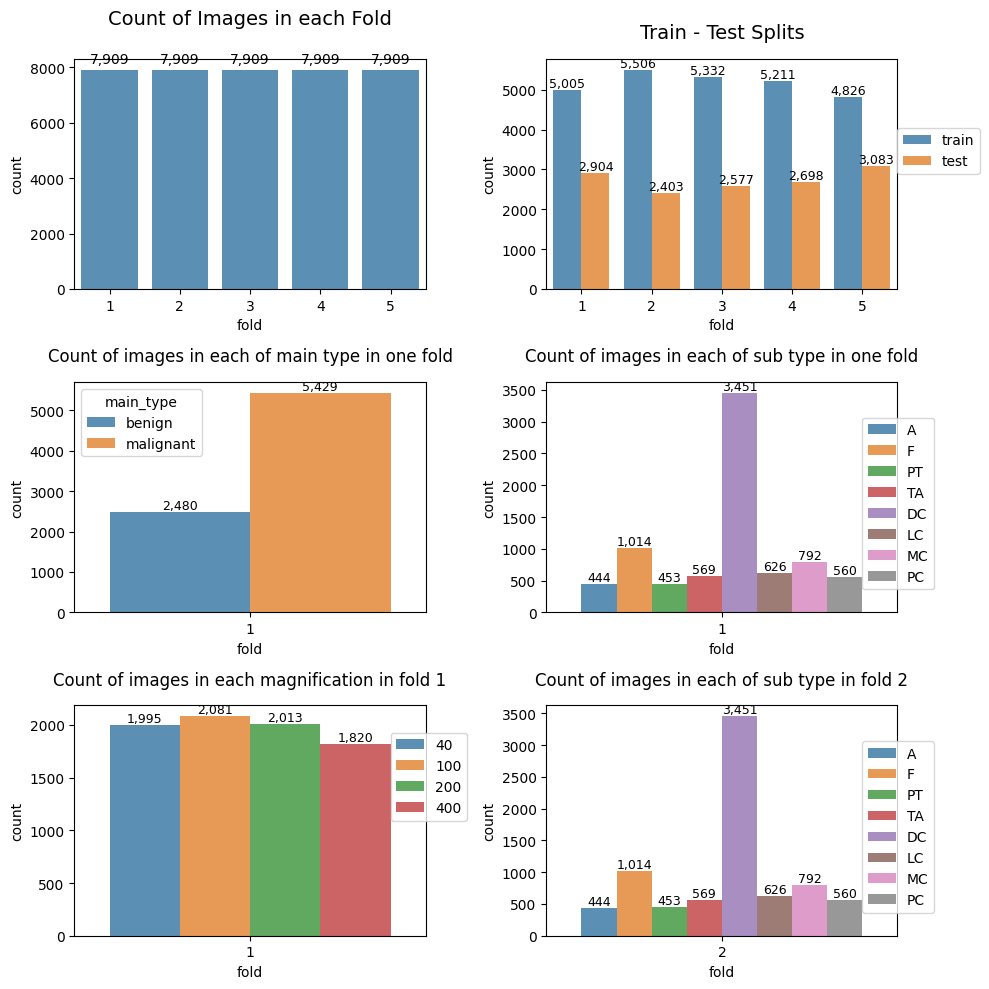

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), tight_layout=True)
# Plot image count in each fold
sb.countplot(data=fold_data, x="fold", color="C0", ax=ax[0][0], alpha=0.8)
bars = ax[0][0].containers[0]
ax[0][0].bar_label(bars, padding=3,
                labels=[f"{x:,.0f}" for x in bars.datavalues])

ax[0][0].set_title("Count of Images in each Fold", size=14, pad=25)

# Plot train-test split
sb.countplot(data=fold_data, x="fold", hue="grp", palette="tab10",
              ax=ax[0][1], alpha=0.8)
for bars in ax[0][1].containers:
    ax[0][1].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)

ax[0][1].set_title("Train - Test Splits", size=14, pad=15)
ax[0][1].legend(loc=(1, 0.5));

# Plot image count in each main type
sb.countplot(data=fold_data[fold_data.fold==1], x="fold", hue="main_type", palette="tab10",
              ax=ax[1][0], alpha=0.8)
for bars in ax[1][0].containers:
    ax[1][0].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)

ax[1][0].set_title("Count of images in each of main type in one fold", size=12, pad=15)


# Plot image count in each sub type
sb.countplot(data=fold_data[fold_data.fold==1], x="fold", hue="sub_type", palette="tab10",
              ax=ax[1][1], alpha=0.8)
for bars in ax[1][1].containers:
    ax[1][1].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)

ax[1][1].set_title("Count of images in each of sub type in one fold", size=12, pad=15)
ax[1][1].legend(loc=(0.9, 0.1))

# Plot image count in each magnification
sb.countplot(data=fold_data[fold_data.fold==1], x="fold", hue="mag", palette="tab10",
              ax=ax[2][0], alpha=0.8)
for bars in ax[2][0].containers:
    ax[2][0].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)

ax[2][0].set_title("Count of images in each magnification in fold 1", size=12, pad=15)
ax[2][0].legend(loc=(0.9, 0.5))

# Plot image count in each sub type
sb.countplot(data=fold_data[fold_data.fold==2], x="fold", hue="sub_type", palette="tab10",
              ax=ax[2][1], alpha=0.8)
for bars in ax[2][1].containers:
    ax[2][1].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)

ax[2][1].set_title("Count of images in each of sub type in fold 2", size=12, pad=15)
ax[2][1].legend(loc=(0.9, 0.1))

In [ ]:
for i in range(1,6):
    print(f'fold {i}')
    print(pd.DataFrame({'num':fold_data[fold_data.fold==i].sub_type.value_counts()}).T)


fold 1
       DC     F   MC   LC   TA   PC   PT    A
num  3451  1014  792  626  569  560  453  444
fold 2
       DC     F   MC   LC   TA   PC   PT    A
num  3451  1014  792  626  569  560  453  444
fold 3
       DC     F   MC   LC   TA   PC   PT    A
num  3451  1014  792  626  569  560  453  444
fold 4
       DC     F   MC   LC   TA   PC   PT    A
num  3451  1014  792  626  569  560  453  444
fold 5
       DC     F   MC   LC   TA   PC   PT    A
num  3451  1014  792  626  569  560  453  444


In [ ]:
#Choose any fold dataset (eg. fold 1), split it into train set(70%) and test set(30%)
img_data = fold_data[fold_data.fold==1].drop(columns=['fold','grp'])
test = img_data.sample(frac=0.3,random_state=SEED)
train = img_data.drop(test.index)
train.reset_index(inplace=True)
train.drop(columns=['index'],inplace=True)
test.reset_index(inplace=True)
test.drop(columns=['index'],inplace=True)
train.shape,test.shape

((5536, 4), (2373, 4))

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train2 = le.fit_transform(train.main_type)
y_test2 = le.transform(test.main_type)
main_classname = list(le.classes_)

le1 = preprocessing.LabelEncoder()
y_train8 = le1.fit_transform(train.sub_type)
y_test8 = le1.transform(test.sub_type)
sub_classname = list(le1.classes_)


y_train8,y_test8

(array([0, 0, 0, ..., 5, 5, 5]), array([1, 1, 6, ..., 1, 1, 5]))

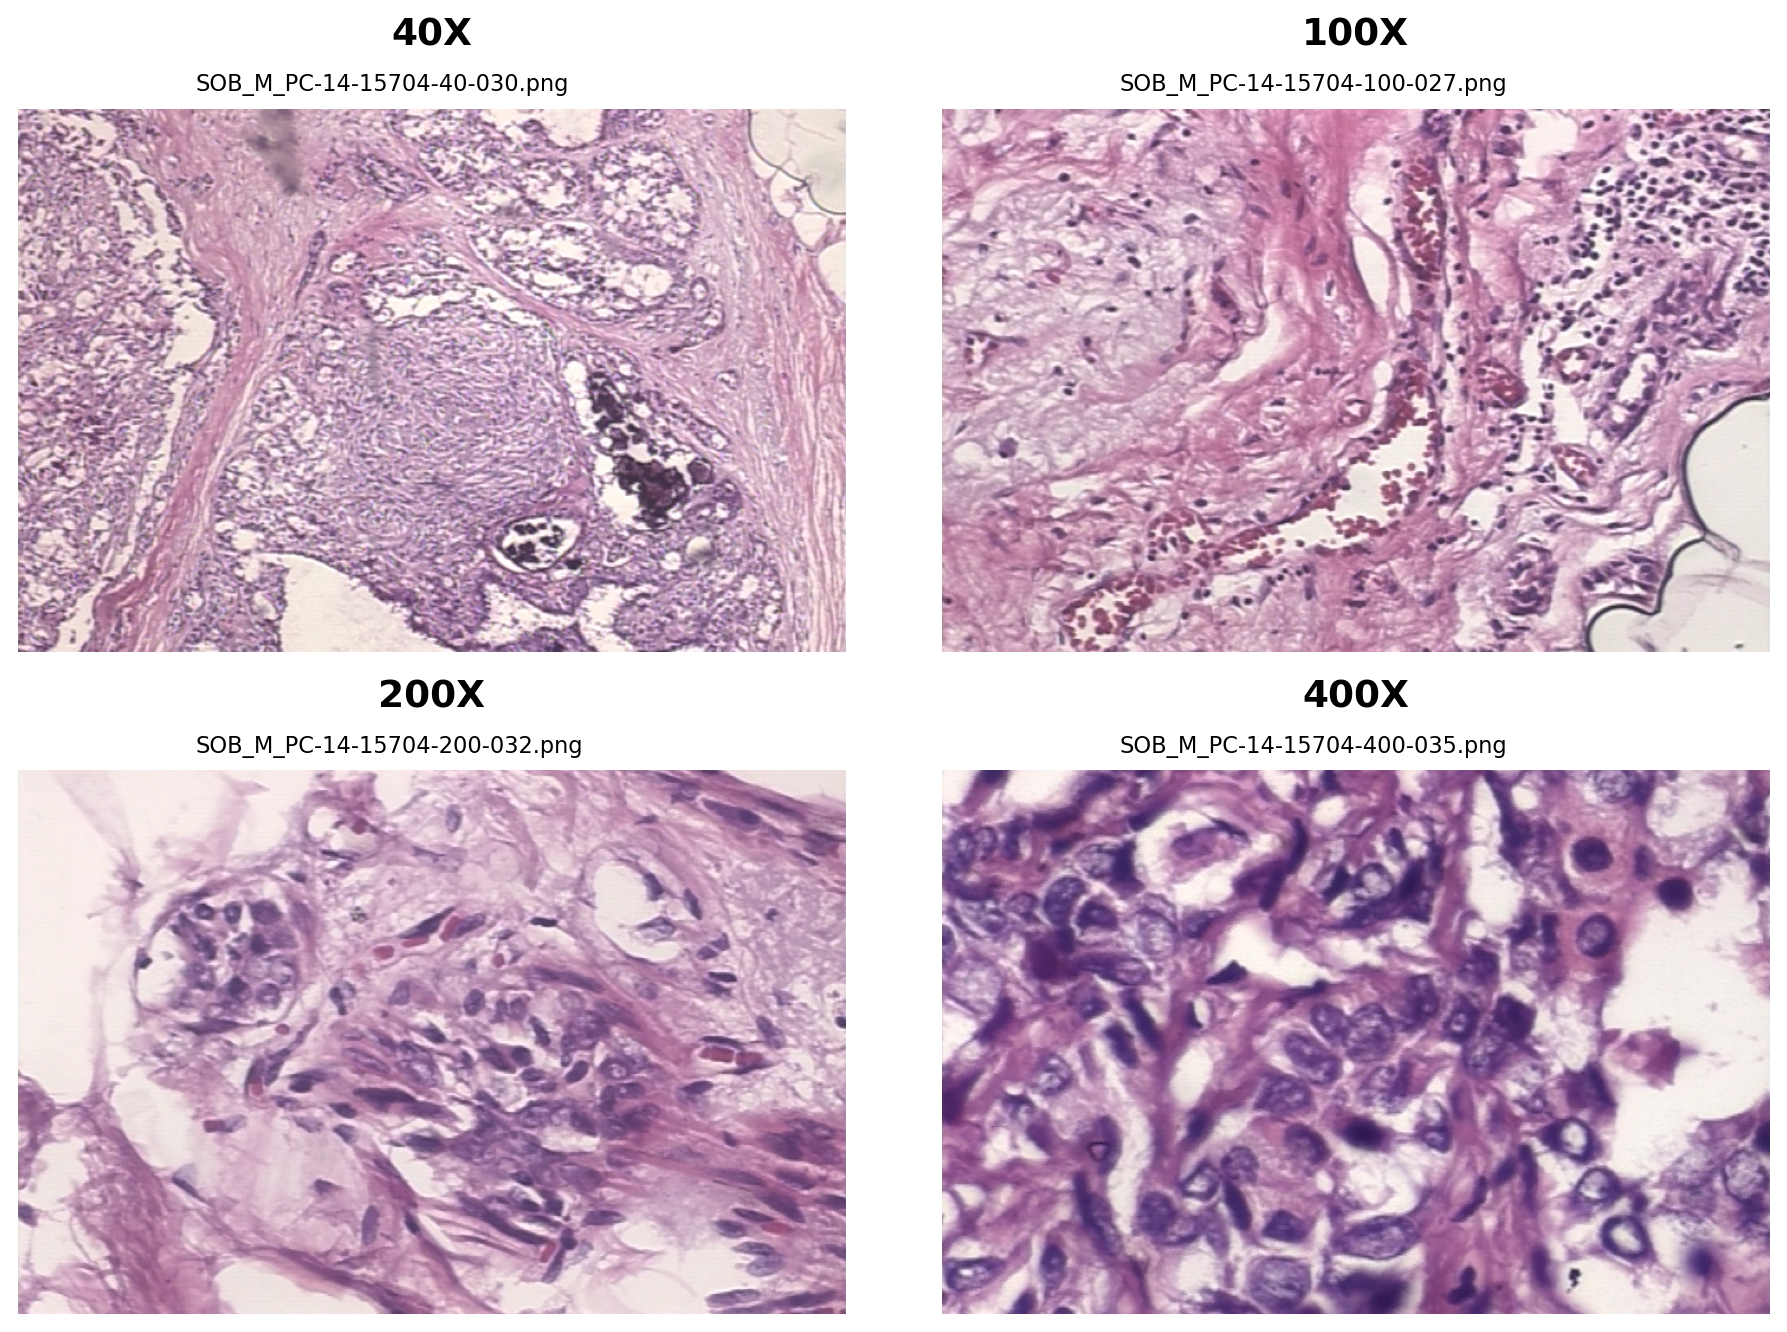

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7.5), dpi=180, tight_layout=True)
sample_images = train.groupby("mag", as_index=False).last()
for ax, row in zip(axes.flat, sample_images.itertuples()):
    img = Image.open(row.filename)
    ax.imshow(img)
    ax.set_title(f"{row.mag}X", size=15, pad=25, weight=600)
    ax.text(150, -15, row.filename.split("/")[-1], size=9)
    ax.axis("off")

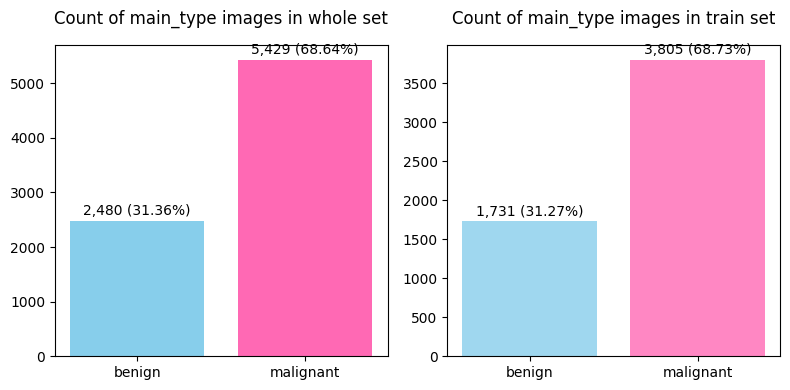

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), tight_layout=True)

# Plot image count/prop in each main type
main_whole = img_data["main_type"].value_counts(ascending=True)
ax[0].bar(main_whole.index,main_whole,color=["skyblue", "hotpink"])
ax[0].bar_label(ax[0].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(img_data):.2%})" for x in main_whole])
ax[0].set_title("Count of main_type images in whole set", size=12, pad=15)

# Plot image count/prop in each sub type
main_train = train["main_type"].value_counts(ascending=True)
ax[1].bar(main_train.index,main_train,color=["skyblue", "hotpink"], alpha=0.8)
ax[1].bar_label(ax[1].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in main_train])
ax[1].set_title("Count of main_type images in train set", size=12, pad=15)
plt.show()

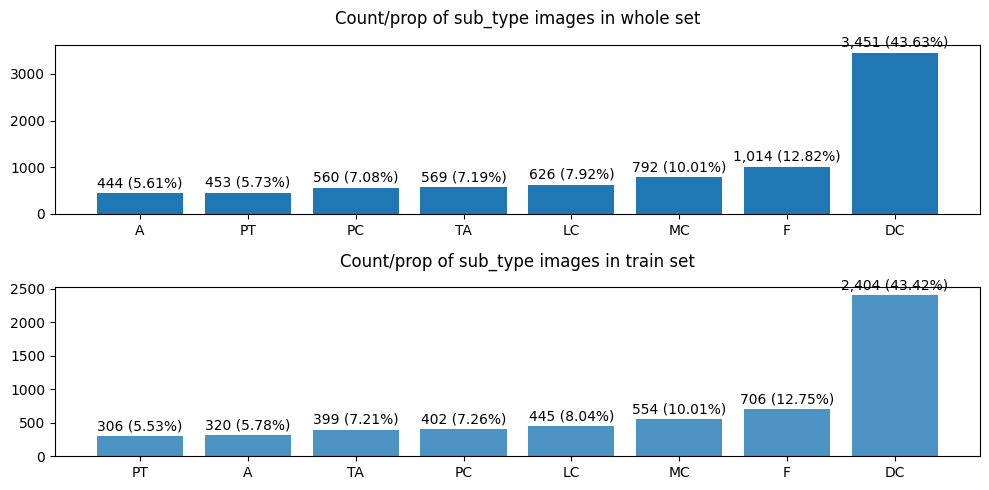

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 5), tight_layout=True)
# Plot image count/prop in each sub type for whole set
sub_whole = img_data["sub_type"].value_counts(ascending=True)
ax[0].bar(sub_whole.index,sub_whole)
ax[0].bar_label(ax[0].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(img_data):.2%})" for x in sub_whole])
ax[0].set_title("Count/prop of sub_type images in whole set", size=12, pad=15)

# Plot image count/prop in each sub type for train set
sub_train = train["sub_type"].value_counts(ascending=True)
ax[1].bar(sub_train.index,sub_train, alpha=0.8)
ax[1].bar_label(ax[1].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in sub_train])
ax[1].set_title("Count/prop of sub_type images in train set", size=12, pad=15)
plt.show()

In [ ]:
from torch.utils.data import DataLoader
IMG_SIZE = 224
BATCH_SIZE = 32

# Define class to load image data
class load_data(torch.utils.data.Dataset):
    def __init__(self, X_df,y):
        self.X = X_df
        self.y = y
        self.T = transforms.Compose([
                    transforms.Resize(IMG_SIZE),
                    transforms.CenterCrop(IMG_SIZE),
                    transforms.ToTensor()])
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        row = self.X.iloc[index]
        img = Image.open(row['filename'])
        return self.T(img),self.y[index]


# load data batch by bathc
loader = DataLoader(
  load_data(train,y_train2),
  batch_size = 16)


def  img_mean_and_sd(loader):

    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])

        #comput first and second moment batch by batch
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    img_mean, img_std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
    return img_mean,img_std

#img_mean, img_std = img_mean_and_sd(loader)
#print("Images' mean and std: \n", img_mean, img_std)

img_mean=[0.7879, 0.6266, 0.7660]
img_std=[0.1244, 0.1760, 0.1081]

In [ ]:
# Define class to load and transform image data
class load_data(torch.utils.data.Dataset):
    def __init__(self, X_df, y):
        self.X = X_df
        self.y = y
        self.T1 = transforms.Compose([
                    transforms.RandomResizedCrop(IMG_SIZE),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])
        self.T2 = transforms.Compose([
                    transforms.Resize(IMG_SIZE),
                    transforms.CenterCrop(IMG_SIZE),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        row = self.X.iloc[index]
        img = Image.open(row['filename'])
        if self.X.name == 'train': return self.T1(img),self.y[index]
        else: return self.T2(img),self.y[index]

# Prepare training and validation datasets for binary classfication
X_train, X_valid, y_train, y_valid = train_test_split(train, y_train2, test_size=0.25, random_state=SEED)
X_train.name = 'train'
X_valid.name = 'val'
test.name = 'test'
train.name = 'train'

# reset index
X_train.reset_index(inplace=True)
X_train.drop(columns=['index'],inplace=True)
X_valid.reset_index(inplace=True)
X_valid.drop(columns=['index'],inplace=True)

#All train images get through T1: resized, randomw size cropped, H flip, transformed to tensor and normalized.
#All validate and tesat images get through T2: center cropped, tranformed to tensor and normalized.
train_ds = load_data(X_train,y_train)
valid_ds = load_data(X_valid,y_valid)
test_ds = load_data(test,y_test2)

# Prepare training and validation datasets for 8-class classfication
X_train_8, X_valid_8, y_train_8, y_valid_8 = train_test_split(train, y_train8, test_size=0.25, random_state=SEED)
X_train_8.name = 'train'
X_valid_8.name = 'val'

# reset index
X_train_8.reset_index(inplace=True)
X_train_8.drop(columns=['index'],inplace=True)
X_valid_8.reset_index(inplace=True)
X_valid_8.drop(columns=['index'],inplace=True)

train_ds_8 = load_data(X_train_8,y_train_8)
valid_ds_8 = load_data(X_valid_8,y_valid_8)
test_ds_8 = load_data(test,y_test8)

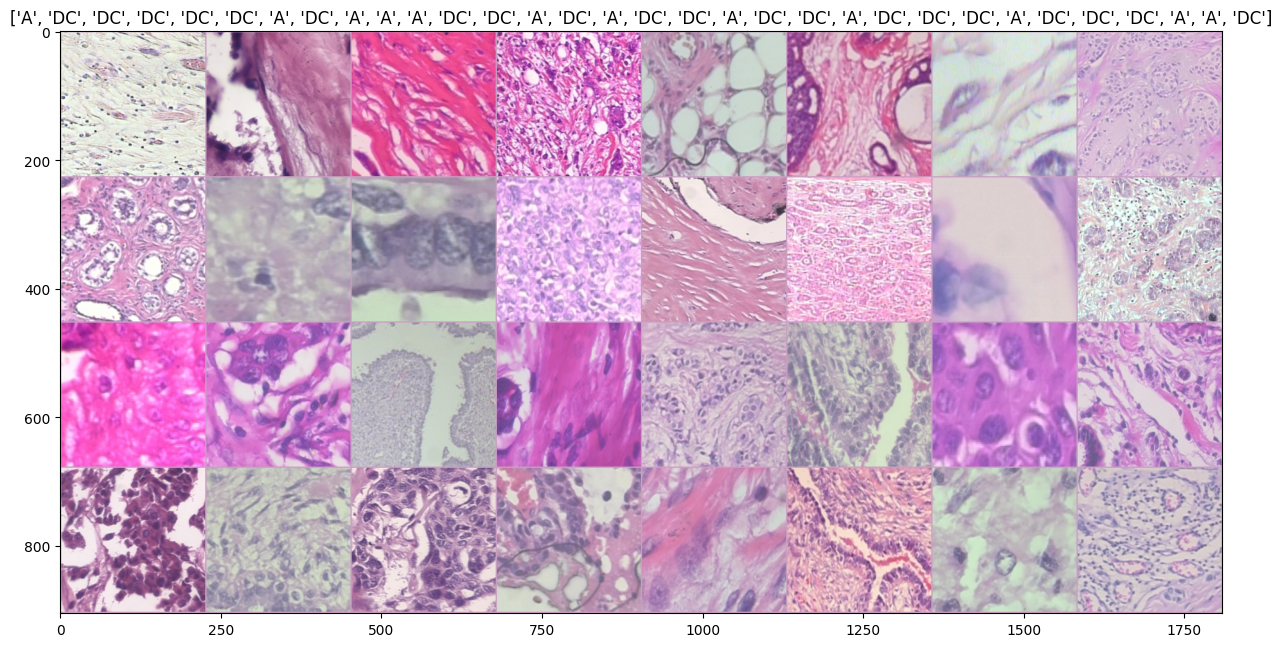

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(img_mean)
    std = np.array(img_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of training data
train_ds1 = DataLoader(load_data(X_train,y_train), batch_size=BATCH_SIZE, shuffle=True)
inputs, classes = next(iter(train_ds1))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[sub_classname[x] for x in classes])

In [ ]:
#Build resnet50 pretrained model
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        num_ftrs = model.fc.in_features

        model.fc = nn.Sequential(
             nn.Linear(num_ftrs, 1000),
             nn.ReLU(),
             nn.Linear(1000, 128),
             nn.ReLU(),
             nn.Linear(128, output_features)
        )
        self.model = model

        mps_device = torch.device("mps")
        # Move your model to mps just like any other device
        #model.to(mps_device)

    def forward(self, x):
        return self.model(x)

DEVICE = 'cuda'


prenet = PretrainedModel(2)
print('Pretrained model ready!')


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 34.3MB/s]


Pretrained model ready!


#Search the learning rate
#Use torch-lr-finder to search the learning rate range when using different optimizers.
optimizer = optim.SGD
LR suggestion: steepest gradient
Suggested LR: 1.66E-01

In [ ]:
from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer
from torch.optim.lr_scheduler import CyclicLR

lrscheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.3)

freezer = Freezer(lambda x: not x.startswith('model.fc'))

In [ ]:
#Train model with Adam optimizer for 2 classes case
#1.Train the model with step LR scheduler and validate with predefined validation set

from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer, ProgressBar, EarlyStopping, Checkpoint, EpochScoring
from torch.optim.lr_scheduler import CyclicLR

freezer = Freezer(lambda x: not x.startswith('model.fc'))
checkpoint = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam', monitor='valid_loss_best')
early_stopping = EarlyStopping(monitor='valid_loss', patience=3)


lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.5)
cp = Checkpoint(dirname='/content/drive/MyDrive/breast/BreaKHis_record/Adam')
train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/breast/BreaKHis_record/Adam')


net = NeuralNetClassifier(
    PretrainedModel(2),
    criterion=nn.CrossEntropyLoss,
    lr=0.0003,
    batch_size=32,
    max_epochs=30,
    #module__output_features=2,
    optimizer=optim.Adam,
    optimizer__weight_decay=1e-4,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds),
    callbacks=[lrscheduler,cp,train_end_cp, ProgressBar(), checkpoint, EpochScoring(scoring='accuracy', on_train=True)],
    #callbacks=[lrscheduler,cp,train_end_cp],
    #callbacks=[lrscheduler,cp,train_end_cp, ProgressBar(), checkpoint, early_stopping, EpochScoring(scoring='accuracy', on_train=True)],

    device = 'cuda'

)

#_ = net.fit(train_ds,y=None)
print('Training complete!')

Training complete!


In [ ]:
# #smaller lr, train on test set
# lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.6)
# cp = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam1')
# train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/breast/BreaKHis_record/Adam1')
# net1 = NeuralNetClassifier(
#     PretrainedModel(2),
#     criterion=nn.CrossEntropyLoss,
#     lr=0.0001,
#     batch_size=32,
#     max_epochs=15,
#     optimizer=optim.Adam,
#     optimizer__weight_decay=1e-4,
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=2,
#     iterator_valid__shuffle=False,
#     iterator_valid__num_workers=2,
#     train_split=predefined_split(test_ds),
#     callbacks=[lrscheduler,cp,train_end_cp],
#     device = 'cuda'
#     #device = torch.device("mps")
# )

# net1.initialize()
# net1.load_params(f_params='/content/drive/MyDrive/breast/BreaKHis_record/Adam/params.pt')
# _ = net1.fit(load_data(train,y_train2),y=None)


In [ ]:
# #smaller lr and larger batch size
# from skorch.callbacks import LoadInitState
# load_state = LoadInitState(cp)
# lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.3)
# cp = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam2')
# train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam2')
# net1 = NeuralNetClassifier(
#     PretrainedModel(2),
#     criterion=nn.CrossEntropyLoss,
#     lr=0.00001,
#     batch_size=64,
#     max_epochs=20,
#     optimizer=optim.Adam,
#     optimizer__weight_decay=1e-4,
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=2,
#     iterator_valid__shuffle=False,
#     iterator_valid__num_workers=2,
#     train_split=predefined_split(test_ds),
#     callbacks=[lrscheduler,cp,train_end_cp,load_state],
#     #device = 'cuda'
#     device = torch.device("mps")
# )

# net1.initialize()
# net1.load_params(f_params='/content/drive/MyDrive/breast/BreakHis_record/Adam1/params.pt')
# _ = net1.fit(load_data(train,y_train2),y=None)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


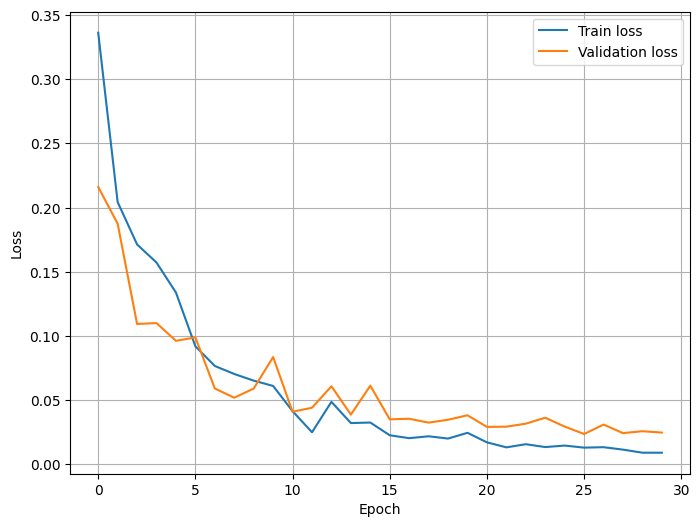

In [ ]:
# plot the train and validation loss curve


val_loss=[]
train_loss=[]
net.initialize()
net.load_params(f_params='/content/drive/MyDrive/breast/BreaKHis_record/Adam/train_end_params.pt',
                f_history='/content/drive/MyDrive/breast/BreaKHis_record/Adam/train_end_history.json')

for i in range(30):
    val_loss.append(net.history[i]['valid_loss'])
    train_loss.append(net.history[i]['train_loss'])

plt.figure(figsize=(8,6))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

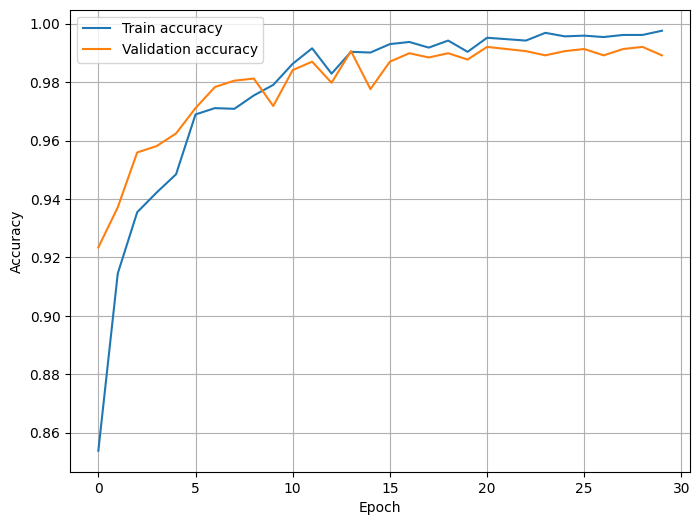

In [ ]:
val_acc=[]
train_acc=[]

for i in range(30):
    val_acc.append(net.history[i]['valid_acc'])
    train_acc.append(net.history[i]['accuracy'])

plt.figure(figsize=(8,6))
plt.plot(train_acc, label='Train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# net1 = NeuralNetClassifier(
#     PretrainedModel(2),
#     criterion=nn.CrossEntropyLoss,
#     lr=0.0003,
#     batch_size=32,
#     max_epochs=20,
#     optimizer=optim.Adam,
#     optimizer__weight_decay=1e-4,
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=2,
#     iterator_valid__shuffle=False,
#     iterator_valid__num_workers=2,
#     train_split=predefined_split(valid_ds),
#     callbacks=[lrscheduler,cp,train_end_cp],
#     device = 'cuda'
# )

#net.initialize()
#net.load_params(f_params='/content/drive/MyDrive/breast/BreakHis_record/Adam/params.pt')
y_pred = net.predict(test_ds)
accuracy2 = accuracy_score(y_test2, y_pred)
print(f'The test accuracy for binary classification:   {round(accuracy2*100,2)}%')

The test accuracy for binary classification:   98.61%


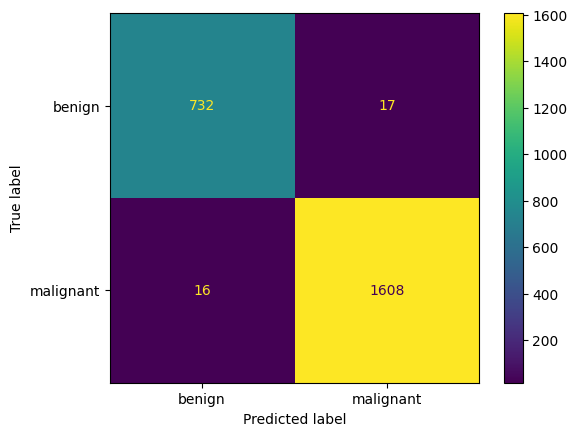

              precision    recall  f1-score   support

      benign     0.9786    0.9773    0.9780       749
   malignant     0.9895    0.9901    0.9898      1624

    accuracy                         0.9861      2373
   macro avg     0.9841    0.9837    0.9839      2373
weighted avg     0.9861    0.9861    0.9861      2373

Accurancy for benign: 0.9861 
Accurancy for malignant: 0.9861 


In [ ]:
#Prediction of 2-class classifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=main_classname)
disp.plot()
plt.show()
print(classification_report(y_test2, y_pred, target_names=main_classname, digits=4))
per_class_accuracies = {}
for idx, cls in enumerate(main_classname):
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    true_positives = cm[idx, idx]
    per_class_accuracies[cls] = round((true_positives + true_negatives) / np.sum(cm),4)
    print(f'Accuracy for {cls}: {per_class_accuracies[cls]} ')

In [ ]:
#Train model with Adam optimizer for 8 classes case
#Train the model with step LR scheduler and validate with predefined validation set

from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer, ProgressBar, EarlyStopping, Checkpoint, EpochScoring
from torch.optim.lr_scheduler import CyclicLR

#freezer = Freezer(lambda x: not x.startswith('model.fc'))
checkpoint = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8', monitor='valid_loss_best')
#early_stopping = EarlyStopping(monitor='valid_loss', patience=3)


#lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.5)
cp = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8')
train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8')

net = NeuralNetClassifier(
    PretrainedModel(8),
    criterion=nn.CrossEntropyLoss,
    lr=0.0003,
    batch_size=32,
    max_epochs=50,
    optimizer=optim.Adam,
    optimizer__weight_decay=1e-4,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds_8),
    callbacks=[lrscheduler,cp,train_end_cp, ProgressBar(), checkpoint, EpochScoring(scoring='accuracy', on_train=True)],
    #callbacks=[lrscheduler,cp,train_end_cp],
    #callbacks=[lrscheduler,cp,train_end_cp, ProgressBar(), checkpoint, early_stopping, EpochScoring(scoring='accuracy', on_train=True)],
    device = 'cuda'
    #device = torch.device("mps")
)

#_ = net.fit(train_ds_8,y=None)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


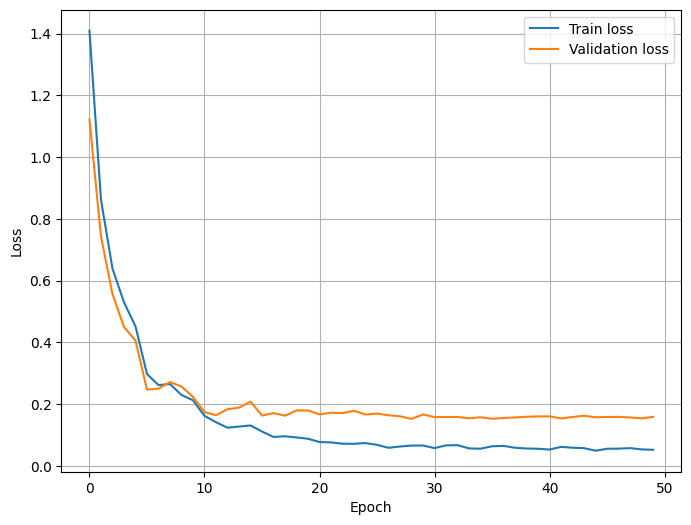

In [ ]:
#plot the train and validation loss curve
val_loss=[]
train_loss=[]
net.initialize()
net.load_params(f_params='/content/drive/MyDrive/breast/BreakHis_record/Adam8/train_end_params.pt',
                 f_history='/content/drive/MyDrive/breast/BreakHis_record/Adam8/train_end_history.json')
for i in range(50):
    val_loss.append(net.history[i]['valid_loss'])
    train_loss.append(net.history[i]['train_loss'])

plt.figure(figsize=(8,6))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

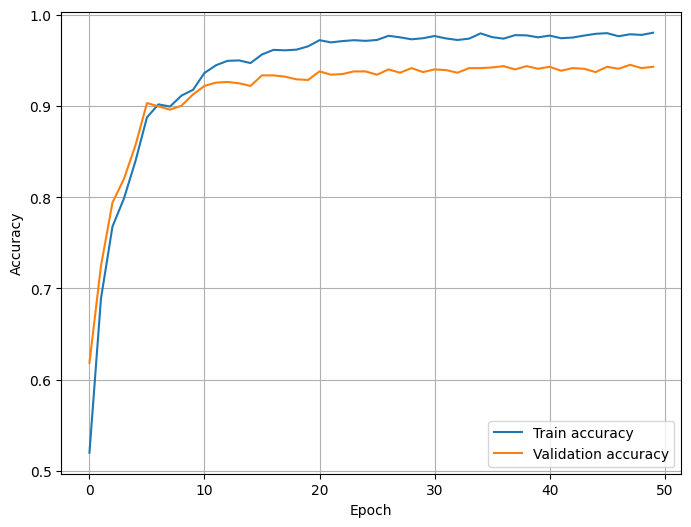

In [ ]:
val_acc=[]
train_acc=[]

for i in range(50):
    val_acc.append(net.history[i]['valid_acc'])
    train_acc.append(net.history[i]['accuracy'])

plt.figure(figsize=(8,6))
plt.plot(train_acc, label='Train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()


In [ ]:
# #Prediction of 8-class classifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

y_pred8 = net.predict(test_ds_8)
accuracy8 = accuracy_score(y_test8, y_pred8)
print(f'The test accuracy for 8-class classification: {round(accuracy8*100,2)}%')

The test accuracy for 8-class classification: 94.73%


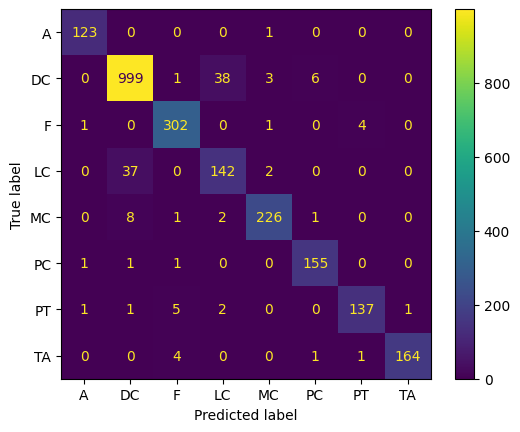

              precision    recall  f1-score   support

           A     0.9762    0.9919    0.9840       124
          DC     0.9551    0.9542    0.9546      1047
           F     0.9618    0.9805    0.9711       308
          LC     0.7717    0.7845    0.7781       181
          MC     0.9700    0.9496    0.9597       238
          PC     0.9509    0.9810    0.9657       158
          PT     0.9648    0.9320    0.9481       147
          TA     0.9939    0.9647    0.9791       170

    accuracy                         0.9473      2373
   macro avg     0.9430    0.9423    0.9425      2373
weighted avg     0.9477    0.9473    0.9474      2373

Accuracy for A: 99.83% 
Accuracy for DC: 96.0% 
Accuracy for F: 99.24% 
Accuracy for LC: 96.59% 
Accuracy for MC: 99.2% 
Accuracy for PC: 99.54% 
Accuracy for PT: 99.37% 
Accuracy for TA: 99.71% 


In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test8, y_pred8)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sub_classname)
disp.plot()
plt.show()
print(classification_report(y_test8, y_pred8, target_names=sub_classname, digits=4))
per_class_accuracies = {}
for idx, cls in enumerate(sub_classname):
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    true_positives = cm[idx, idx]
    per_class_accuracies[cls] = round((true_positives + true_negatives) / np.sum(cm)*100,2)
    print(f'Accuracy for {cls}: {per_class_accuracies[cls]}% ')

In [ ]:
#Prepare the balanced data Over-sampling using SMOTE
#Perform over-sampling using SMOTE to increase minority class size to be same as majority class 'DC'.

from imblearn.over_sampling import SMOTEN
print(f'The train set shape before over-sampling: {train.shape}')
smote = SMOTEN(sampling_strategy='auto',random_state=SEED)
#sample_strategy = {0: 2000, 1: 2000, 2: 2000, 3: 2000, 4: 2000}
#smote = SMOTEN(sampling_strategy=sample_strategy, random_state=SEED)
Xtrain_sm,ytrain_sm8 = smote.fit_resample(train,y_train8)
#ytrain_sm2 = le.transform(Xtrain_sm.main_type)
print(f"After over sampling, the train set shape : {Xtrain_sm.shape}")
print(f"Sample count in each class: {Xtrain_sm.sub_type.value_counts()}")

The train set shape before over-sampling: (5536, 4)
After over sampling, the train set shape : (19232, 4)
Sample count in each class: A     2404
F     2404
PT    2404
TA    2404
DC    2404
LC    2404
MC    2404
PC    2404
Name: sub_type, dtype: int64


In [ ]:
#Load and transform the image data Apply RandomHorizontalFlip() and transforms.RandomVerticalFlip() during loading data to
#reduce duplicates when add more images for minority class.

# Define class to load and transform image data
torch.manual_seed(SEED)
class load_data(torch.utils.data.Dataset):
    def __init__(self, X_df, y):
        self.X = X_df
        self.y = y
        self.T1 = transforms.Compose([
                    transforms.Resize((IMG_SIZE,IMG_SIZE)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(90),
                    transforms.RandomRotation(270),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])
        self.T2 = transforms.Compose([
                    transforms.Resize((IMG_SIZE,IMG_SIZE)),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        row = self.X.iloc[index]
        img = Image.open(row['filename'])
        if self.X.name == 'train': return self.T1(img),self.y[index]
        else: return self.T2(img),self.y[index]

# # Prepare training and validation datasets for binary classfication
# X_train, X_valid, y_train, y_valid = train_test_split(Xtrain_sm, ytrain_sm2, test_size=0.25, random_state=SEED)
# X_train.name = 'train'
# X_valid.name = 'val'
# test.name = 'test'
# train.name = 'train'

# # reset index
# X_train.reset_index(inplace=True)
# X_train.drop(columns=['index'],inplace=True)
# X_valid.reset_index(inplace=True)
# X_valid.drop(columns=['index'],inplace=True)

# train_ds_sm = load_data(X_train,y_train)
# valid_ds_sm = load_data(X_valid,y_valid)
# test_ds = load_data(test,y_test2)

# Prepare training and validation datasets for 8-class classfication, 10% for test
X_train_8, X_valid_8, y_train_8, y_valid_8 = train_test_split(Xtrain_sm, ytrain_sm8, test_size=0.25, random_state=SEED)
X_train_8.name = 'train'
X_valid_8.name = 'val'
test.name = 'test'

# reset index
X_train_8.reset_index(inplace=True)
X_train_8.drop(columns=['index'],inplace=True)
X_valid_8.reset_index(inplace=True)
X_valid_8.drop(columns=['index'],inplace=True)

train_ds_sm8 = load_data(X_train_8,y_train_8)
valid_ds_sm8 = load_data(X_valid_8,y_valid_8)
test_ds_8 = load_data(test,y_test8)
print(f"After over sampling, the train set shape : {X_train_8.shape}")
print(f"After over sampling, the validation set shape : {X_valid_8.shape}")

After over sampling, the train set shape : (14424, 4)
After over sampling, the validation set shape : (4808, 4)


In [ ]:
from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer
from torch.optim.lr_scheduler import CyclicLR

lrscheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.3)

freezer = Freezer(lambda x: not x.startswith('model.fc'))

In [ ]:
#Train model with Adam optimizer for 8 classes case Train the model with step LR scheduler and validate with predefined validation set
freezer = Freezer(lambda x: not x.startswith('model.fc'))
checkpoint = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8_sm8', monitor='valid_loss_best')
early_stopping = EarlyStopping(monitor='valid_loss', patience=3)


lrscheduler = LRScheduler(policy='StepLR', step_size=10, gamma=0.5)
cp = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam_sm8')
train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam_sm8')

net = NeuralNetClassifier(
    PretrainedModel(8),
    criterion=nn.CrossEntropyLoss,
    lr=0.0003,
    batch_size=32,
    max_epochs=30,
    optimizer=optim.Adam,
    optimizer__weight_decay=1e-4,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds_sm8),
    callbacks=[lrscheduler,cp,train_end_cp, ProgressBar(), checkpoint, EpochScoring(scoring='accuracy', on_train=True)],
    #callbacks=[lrscheduler,cp,train_end_cp],
    #callbacks=[lrscheduler,cp,train_end_cp, ProgressBar(), checkpoint, early_stopping, EpochScoring(scoring='accuracy', on_train=True)],

    device = 'cuda'
)

_ = net.fit(train_ds_sm8,y=None)

  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      lr        dur
-------  ----------  ------------  -----------  ------------  ----  ------  ---------
      1      0.8658        0.4136       0.9052        0.2749     +  0.0003  1695.6861


      2      0.9321        0.1940       0.9476        0.1474     +  0.0003  357.4082


      3      0.9493        0.1481       0.9574        0.1130     +  0.0003  355.1276


      4      0.9545        0.1272       0.9459        0.1790        0.0003  354.4007


      5      0.9604        0.1180       0.9597        0.1218        0.0003  347.7365


      6      0.9614        0.1107       0.9022        0.3151        0.0003  345.3119


      7      0.9635        0.1115       0.9295        0.1463        0.0003  349.5613


      8      0.9614        0.1132       0.9646        0.1021     +  0.0003  347.3028


      9      0.9707        0.0832       0.9663        0.1091        0.0003  349.5207


     10      0.9714        0.0782       0.9565        0.1316        0.0003  346.2468


     11      0.9821        0.0468       0.9757        0.0742     +  0.0001  349.1908


     12      0.9841        0.0427       0.9782        0.0656     +  0.0001  352.3110


     13      0.9847        0.0392       0.9700        0.0935        0.0001  349.2650


     14      0.9861        0.0350       0.9765        0.0767        0.0001  353.8152


     15      0.9854        0.0388       0.9784        0.0631     +  0.0001  354.2257


     16      0.9850        0.0390       0.9746        0.0845        0.0001  358.7090


     17      0.9870        0.0355       0.9755        0.0763        0.0001  352.2482


     18      0.9849        0.0393       0.9740        0.0740        0.0001  360.3165


     19      0.9852        0.0389       0.9752        0.0743        0.0001  360.6973


     20      0.9875        0.0305       0.9759        0.0797        0.0001  360.2645


     21      0.9928        0.0180       0.9817        0.0575     +  0.0001  364.6290


     22      0.9931        0.0152       0.9775        0.0637        0.0001  368.5911


     23      0.9918        0.0161       0.9807        0.0725        0.0001  357.7026


     24      0.9947        0.0129       0.9834        0.0625        0.0001  352.1331


     25      0.9938        0.0146       0.9807        0.0634        0.0001  349.4253


     26      0.9925        0.0165       0.9796        0.0675        0.0001  349.9960


     27      0.9945        0.0117       0.9790        0.0698        0.0001  349.9552


     28      0.9933        0.0172       0.9796        0.0619        0.0001  350.9963


     29      0.9931        0.0167       0.9794        0.0743        0.0001  348.7797


     30      0.9948        0.0119       0.9813        0.0600        0.0001  362.5016


 14%|█▍        | 84/602 [00:48<04:56,  1.75it/s, train_loss=0.00152] 

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


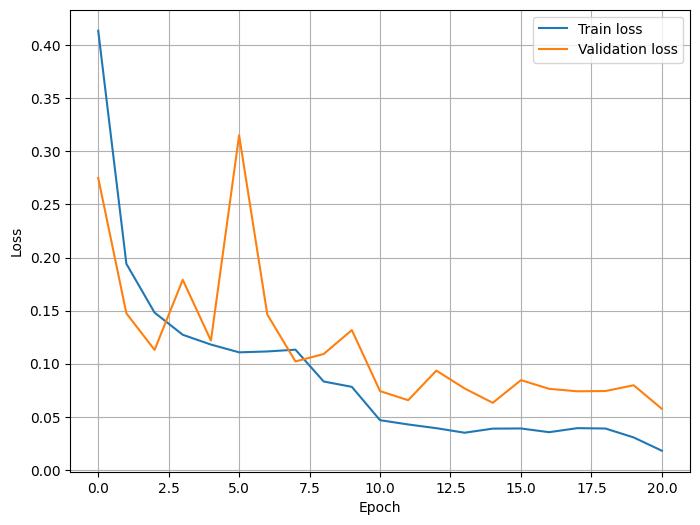

In [ ]:
val_loss=[]
train_loss=[]

net.initialize()
net.load_params(f_params='/content/drive/MyDrive/breast/BreakHis_record/Adam8_sm8/params.pt',
                f_history='/content/drive/MyDrive/breast/BreakHis_record/Adam8_sm8/history.json')

for i in range(21):
    val_loss.append(net.history[i]['valid_loss'])
    train_loss.append(net.history[i]['train_loss'])

plt.figure(figsize=(8,6))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

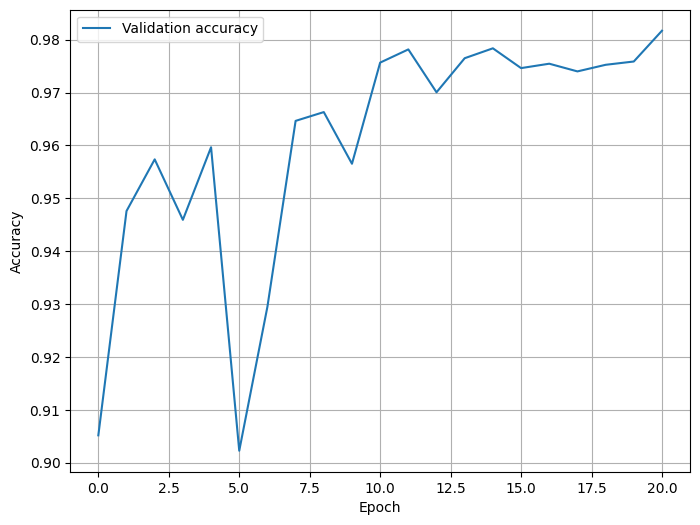

In [ ]:
val_acc=[]
train_acc=[]

for i in range(21):
    val_acc.append(net.history[i]['valid_acc'])
 #   train_acc.append(net.history[i]['accuracy'])

plt.figure(figsize=(8,6))
#plt.plot(train_acc, label='Train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()


In [ ]:
# #Prediction of 5-class classifier
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import cross_val_score

# # lrscheduler = LRScheduler(policy=CyclicLR,base_lr=0.001, max_lr=0.5,step_size_up=len(train_ds_sm8)//2)
# lrscheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.5)
# cp = Checkpoint(dirname='/content/drive/MyDrive/DL/breast/BreaKHis_record/Adam_sm8')
# train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/DL/breast/BreaKHis_record/Adam_sm8')

# net = NeuralNetClassifier(
#     PretrainedModel(8),
#     criterion=nn.CrossEntropyLoss,
#     lr=0.0003,
#     batch_size=32,
#     max_epochs=20,
#     optimizer=optim.Adam,
#     optimizer__weight_decay=1e-4,
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=2,
#     iterator_valid__shuffle=False,
#     iterator_valid__num_workers=2,
#     train_split=predefined_split(valid_ds_sm8),
#     callbacks=[lrscheduler,cp,train_end_cp],
#     device = 'cuda'
# )


# net.initialize()
# net.load_params(f_params='/content/drive/MyDrive/DL/breast/BreaKHis_record/Adam_sm8/train_end_params.pt')


y_pred8 = net.predict(test_ds_8)
accuracy8 = accuracy_score(y_test8, y_pred8)
print(f'The test accuracy for 8-class classification: {round(accuracy8*100,2)}%')

The test accuracy for 8-class classification: 94.18%


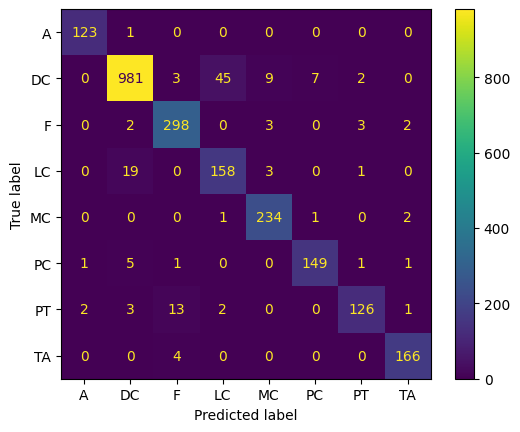

              precision    recall  f1-score   support

           A     0.9762    0.9919    0.9840       124
          DC     0.9703    0.9370    0.9534      1047
           F     0.9342    0.9675    0.9506       308
          LC     0.7670    0.8729    0.8165       181
          MC     0.9398    0.9832    0.9610       238
          PC     0.9490    0.9430    0.9460       158
          PT     0.9474    0.8571    0.9000       147
          TA     0.9651    0.9765    0.9708       170

    accuracy                         0.9418      2373
   macro avg     0.9311    0.9412    0.9353      2373
weighted avg     0.9442    0.9418    0.9424      2373

Accuracy for A: 99.83% 
Accuracy for DC: 95.95% 
Accuracy for F: 98.69% 
Accuracy for LC: 97.01% 
Accuracy for MC: 99.2% 
Accuracy for PC: 99.28% 
Accuracy for PT: 98.82% 
Accuracy for TA: 99.58% 
Confusion Matrix
[[123   1   0   0   0   0   0   0]
 [  0 981   3  45   9   7   2   0]
 [  0   2 298   0   3   0   3   2]
 [  0  19   0 158   3   0   1 

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

confusion_mat = confusion_matrix(y_test8, y_pred8)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=sub_classname)
disp.plot()
plt.show()
sub_classname_str = [str(x) for x in sub_classname]
print(classification_report(y_test8, y_pred8, target_names=sub_classname_str, digits=4))
per_class_accuracies = {}
for idx, cls in enumerate(sub_classname):
    true_negatives = np.sum(np.delete(np.delete(confusion_mat, idx, axis=0), idx, axis=1))
    true_positives = confusion_mat[idx, idx]
    per_class_accuracies[cls] = round((true_positives + true_negatives) / np.sum(confusion_mat)*100,2)
    print(f'Accuracy for {cls}: {per_class_accuracies[cls]}% ')
print("Confusion Matrix")
print(confusion_mat)